<a href="https://colab.research.google.com/github/Eason0227/Turbofan-Engine-Remaining-Useful-Life-Prediction/blob/main/DL_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NASA Turbofan Jet Engine DataSet - RUL prediction

Reference  
https://www.kaggle.com/code/yahyamomtaz/rul-prediction-using-lstm-for-aircraft-engine  
https://www.kaggle.com/code/easmeileabrhim/rul-predict-by-cnn-lstm

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import time
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from google.colab import drive
drive.mount('/content/drive')

# model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.layers import TimeDistributed, Flatten
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping

Mounted at /content/drive


In [ ]:
index_names = ['unit_number', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['sensor_{}'.format(i) for i in range(1,22)]
col_names = index_names + setting_names + sensor_names

In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/NASA Turbofan Jet Engine Data Set/data/'
df_train = pd.read_csv(path+'train_FD001.txt',sep='\s+',header=None,index_col=False,names=col_names) #\s表示以空白為間隔
df_test = pd.read_csv(path+'test_FD001.txt',sep='\s+',header=None,index_col=False,names=col_names)
y_test = pd.read_csv(path+'RUL_FD001.txt',sep='\s+',header=None,index_col=False,names=['RUL'])
y_test.shape

(100, 1)

In [ ]:
train = df_train.copy()
test = df_test.copy()
display(train)
display(test)

,unit_number,time_cycles,setting_1,setting_2,setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,519.49,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,519.68,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,520.01,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,519.67,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640


,unit_number,time_cycles,setting_1,setting_2,setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,194,0.0049,0.0000,100.0,518.67,643.24,1599.45,1415.79,14.62,...,520.69,2388.00,8213.28,8.4715,0.03,394,2388,100.0,38.65,23.1974
13092,100,195,-0.0011,-0.0001,100.0,518.67,643.22,1595.69,1422.05,14.62,...,521.05,2388.09,8210.85,8.4512,0.03,395,2388,100.0,38.57,23.2771
13093,100,196,-0.0006,-0.0003,100.0,518.67,643.44,1593.15,1406.82,14.62,...,521.18,2388.04,8217.24,8.4569,0.03,395,2388,100.0,38.62,23.2051
13094,100,197,-0.0038,0.0001,100.0,518.67,643.26,1594.99,1419.36,14.62,...,521.33,2388.08,8220.48,8.4711,0.03,395,2388,100.0,38.66,23.2699


In [ ]:
print('Shape of the train dataset : ',train.shape)
print('Shape of the test dataset : ',test.shape)

Shape of the train dataset :  (20631, 26)
Shape of the test dataset :  (13096, 26)


Takes datalength and earlyrul as input and creates target RUL.

This function takes in two arguments, data_length and early_rul. It returns an array that represents the remaining useful life (RUL) for each cycle in the input data. If the early_rul_duration is less than or equal to 0, then the target variable is a reversed range of data_length-1 to 0.

接受 datalength 和 earlyrul 作為輸入，並創建目標 RUL。  
這個函數接受兩個參數，data_length 和 early_rul。它返回一個表示輸入數據每個週期的剩餘使用壽命（RUL）的數組。如果 early_rul_duration 小於或等於 0，則目標變量是從 data_length-1 到 0 的逆序範圍。

In [ ]:
def process_targets(data_length, early_rul):
  early_rul_duration = data_length - early_rul # 壽命比early rul 多了多長
  if early_rul_duration <= 0: # 如果壽命小於early rul，targets則不變
    return np.arange(data_length-1, -1, -1)
  else:
    new_early_rul = early_rul * np.ones(early_rul_duration) # 多出多少early rul
    origin_rul = np.arange(early_rul-1, -1, -1)
    return np.append(new_early_rul,origin_rul)

This function takes in input data and target data and processes them with a specified window length and shift size. The output_data is a numpy array with shape (num_batches, window_length, num_features). If target_data is not None, the function also outputs output_targets, a numpy array with shape (num_batches,) containing the target values for each batch.

*   此函數接收輸入數據和目標數據，並使用指定的窗口長度和移位大小處理它們。
*   output_data是一個形狀為(num_batches, window_length, num_features)的numpy陣列
*   該函數還會輸出output_targets，這是一個形狀為(num_batches,)的numpy陣列，其中包含每個批次的目標值。

這個函式主要用於處理測試資料，根據給定的窗口長度、位移和測試窗口數量，將測試資料進行批次處理並返回批次處理後的測試資料和實際的最大測試批次數或指定的測試批次數。

In [ ]:
def process_input_data_with_targets(input_data, target_data , window_length , shift ):
  num_batches = np.int(np.floor((len(input_data) - window_length)/shift)) + 1 # 共有多少組小資料
  num_features = input_data.shape[1] # 每筆資料的特徵數
  output = np.repeat(np.nan, repeats = num_batches * window_length * num_features)
  output_data = output.reshape(num_batches, window_length , num_features)

  if target_data is None: #測試資料無target data
    for batch in range(num_batches):
      output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
    return output_data
  else : #處理訓練資料的target data
    output_targets = np.repeat(np.nan, repeats = num_batches) #target rul
    for batch in range(num_batches):
      window_start = shift * batch
      window_end = window_start + window_length

      output_data[batch,:,:] = input_data[window_start:window_end,:]
      output_targets[batch] = target_data[window_end-1]
    return output_data, output_targets

This function processes the test data for a single engine in preparation for making predictions using a trained model. It takes in the test data for a single engine (test_data_for_an_engine), the window_length and shift parameters that were used in preparing the training data, and the number of test windows (num_test_windows) that should be processed.

* 此函數處理單個引擎的測試數據，為使用經過訓練的模型進行預測做準備
* 它接收單個引擎的測試數據 (test_data_for_an_engine)
* 準備訓練數據時使用的 window_length 和 shift 參數，以及應處理的測試窗口數 (num_test_windows)。


這個函式主要用於處理測試資料，根據給定的窗口長度、位移和測試窗口數量，將測試資料進行批次處理並返回批次處理後的測試資料和實際的最大測試批次數或指定的測試批次數。

In [ ]:
def process_test_data(test_data_for_an_engine, window_length, shift, num_test_windows = 1):

    max_num_test_batches = np.int(np.floor((len(test_data_for_an_engine) - window_length)/shift)) + 1 #共有多少組小資料

    if max_num_test_batches < num_test_windows:
        required_len = (max_num_test_batches -1)* shift + window_length
        batched_test_data_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :],
                                          target_data = None,
                                          window_length = window_length, shift = shift)
        return batched_test_data_for_an_engine, max_num_test_batches
    else:
        required_len = (num_test_windows - 1) * shift + window_length
        batched_test_data_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :],
                                          target_data = None,
                                          window_length = window_length, shift = shift)
        return batched_test_data_for_an_engine, num_test_windows

The default option is to take only the last window of test data for each engine, which amounts to one window. However, if you set the number to a different value, that many windows from the last will be taken, and the final output will be the average of all the windows.

默認選項是只取每個引擎的最後一個窗口的測試數據，這相當於一個窗口。 但是，如果您將數字設置為不同的值，那麼將採用上一個窗口的多個窗口，最終輸出將是所有窗口的平均值。

In [ ]:
drop_labels = ['sensor_1', 'sensor_5','sensor_6','sensor_10', 'sensor_16', 'sensor_18', 'sensor_19']
train_data_first_column = train["unit_number"]
test_data_first_column = test["unit_number"]

scaler = MinMaxScaler()

train_data = scaler.fit_transform(train.drop(columns = ['unit_number'] + setting_names + drop_labels ))
test_data = scaler.transform(test.drop(columns = ['unit_number'] + setting_names+ drop_labels ))

train_data = pd.DataFrame(data = np.c_[train_data_first_column, train_data])
test_data = pd.DataFrame(data = np.c_[test_data_first_column, test_data])

num_train_machines = len(train_data[0].unique())
num_test_machines = len(test_data[0].unique())

It is important to process the training and test data separately since the number of engines in each set may differ.
Since we scale the entire dataset, we do not need to be concerned about the differing number of engines between the training and test sets.

將訓練數據和測試數據分開處理是很重要的，因為每個集合中的引擎數量可能不同。由於我們對整個數據集進行了縮放，所以不需要擔心訓練集和測試集之間引擎數量的差異。

In [ ]:
window_length = 30
shift = 1
early_rul = 125
num_test_windows = 5

## 處理訓練資料

In [ ]:
processed_train_data = []
processed_train_targets = []

for i in np.arange(1, num_train_machines + 1):
    temp_train_data = train_data[train_data[0] == i].drop(columns = [0]).values #每台機器的資料

    temp_train_targets = process_targets(data_length = temp_train_data.shape[0], early_rul = early_rul)
    data_for_a_machine, targets_for_a_machine = process_input_data_with_targets(temp_train_data, temp_train_targets,window_length= window_length, shift = shift)

    processed_train_data.append(data_for_a_machine)
    processed_train_targets.append(targets_for_a_machine)

processed_train_data = np.concatenate(processed_train_data)
processed_train_targets = np.concatenate(processed_train_targets)

## 處理測試資料

In [ ]:
processed_test_data = []
num_test_windows_list = []

for i in np.arange(1, num_test_machines + 1):
    temp_test_data = test_data[test_data[0] == i].drop(columns = [0]).values

    # Prepare test data
    test_data_for_an_engine, num_windows = process_test_data(temp_test_data, window_length=window_length, shift = shift,num_test_windows = num_test_windows)

    processed_test_data.append(test_data_for_an_engine)
    num_test_windows_list.append(num_windows)

processed_test_data = np.concatenate(processed_test_data)
true_rul = y_test.values

# Shuffle training data
index = np.random.permutation(len(processed_train_targets))
processed_train_data, processed_train_targets = processed_train_data[index], processed_train_targets[index]

In [ ]:
print("Processed trianing data shape: ", processed_train_data.shape)
print("Processed training ruls shape: ", processed_train_targets.shape)
print("Processed test data shape: ", processed_test_data.shape)
print("True RUL shape: ", true_rul.shape)

Processed trianing data shape:  (17731, 30, 15)
Processed training ruls shape:  (17731,)
Processed test data shape:  (497, 30, 15)
True RUL shape:  (100, 1)


The shape of processed_train_data is (17731, 30, 14), which means we have 17731 engines, each with 30 time steps and 14 sensor readings at each time step.
The shape of processed_train_targets is (17731,), which means we have the corresponding target RUL values for the 17731 training samples.
The shape of processed_test_data is (497, 30, 14), which means we have 497 test or engines, each with 30 time steps and 14 sensor readings at each time step.
The shape of true_rul is (100,), which means we have the true RUL values for 100 test engines.

處理後的訓練數據的形狀是 (17731, 30, 14)，這意味著我們有 17731 個引擎，每個引擎有 30 個時間步長和每個時間步長的 14 個感測器讀數。
處理後的訓練目標的形狀是 (17731,)，這意味著我們有 17731 個訓練樣本對應的目標 RUL 值。
處理後的測試數據的形狀是 (497, 30, 14)，這意味著我們有 497 個測試引擎，每個引擎有 30 個時間步長和每個時間步長的 14 個感測器讀數。
true_rul 的形狀是 (100,)，這意味著我們有 100 個測試引擎對應的真實 RUL 值。

In [ ]:
# 切分訓練及驗證資料
processed_train_data, processed_val_data, processed_train_targets, processed_val_targets = train_test_split(processed_train_data,
                                                        processed_train_targets,
                                                        test_size = 0.2,
                                                        random_state = 666)
print("Processed train data shape: ", processed_train_data.shape)
print("Processed validation data shape: ", processed_val_data.shape)
print("Processed train targets shape: ", processed_train_targets.shape)
print("Processed validation targets shape: ", processed_val_targets.shape)

Processed train data shape:  (14184, 30, 15)
Processed validation data shape:  (3547, 30, 15)
Processed train targets shape:  (14184,)
Processed validation targets shape:  (3547,)


##  Convolutional Neural Network

In [ ]:
def CNN_model(kernel_size,pool_size):
  input_shape = (window_length, 15)
  model = Sequential([
    layers.Conv1D(128, kernel_size = kernel_size, padding = "same", activation="relu", input_shape = input_shape),
    layers.MaxPooling1D(pool_size= pool_size, padding='same'),
    layers.Conv1D(128,kernel_size = kernel_size, padding = "same", activation="relu"),
    layers.MaxPooling1D(pool_size= pool_size, padding='same'),
    layers.GlobalAveragePooling1D(),
    # layers.Dropout(0.5),
    layers.Dense(96, activation = "relu"),
    layers.Dense(128, activation = "relu"),
    layers.Dense(1)
  ])
  model.compile(loss = "mse", optimizer = tf.keras.optimizers.Adam(learning_rate=0.001))
  return model

CNN_model(kernel_size=3,pool_size=2).summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 30, 128)           5888      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 15, 128)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 15, 128)           49280     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 8, 128)           0         
 1D)                                                             
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                        

## GRU

In [ ]:
def GRU_model():
  input_shape = (window_length, 15)
  model = Sequential([
    layers.GRU(128, input_shape = input_shape , return_sequences=True, activation = "tanh"),
    layers.GRU(64, activation = "tanh", return_sequences = True),
    layers.GRU(32, activation = "tanh"),
    layers.Dense(96, activation = "relu"),
    layers.Dense(128, activation = "relu"),
    layers.Dense(1)
  ])
  model.compile(loss = "mse", optimizer = tf.keras.optimizers.Adam(learning_rate=0.001))
  return model

GRU_model().summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 30, 128)           55680     
                                                                 
 gru_1 (GRU)                 (None, 30, 64)            37248     
                                                                 
 gru_2 (GRU)                 (None, 32)                9408      
                                                                 
 dense_3 (Dense)             (None, 96)                3168      
                                                                 
 dense_4 (Dense)             (None, 128)               12416     
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 118,049
Trainable params: 118,049
Non-tr

## LSTM

In [ ]:
def LSTM_model():
  input_shape = (window_length, 15)
  model = Sequential([
    layers.LSTM(128, input_shape = input_shape , activation = "tanh"),
    layers.Dense(96, activation = "relu"),
    layers.Dense(128, activation = "relu"),
    layers.Dense(1)
  ])
  model.compile(loss = "mse", optimizer = tf.keras.optimizers.Adam(learning_rate=0.001))
  return model

LSTM_model().summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               73728     
                                                                 
 dense_6 (Dense)             (None, 96)                12384     
                                                                 
 dense_7 (Dense)             (None, 128)               12416     
                                                                 
 dense_8 (Dense)             (None, 1)                 129       
                                                                 
Total params: 98,657
Trainable params: 98,657
Non-trainable params: 0
_________________________________________________________________


## Stacked LSTM

In [ ]:
def Stacked_LSTM_model():
  input_shape = (window_length, 15)
  model = Sequential([
    layers.LSTM(128, input_shape = input_shape , return_sequences=True, activation = "tanh"),
    layers.LSTM(64, activation = "tanh", return_sequences = True),
    layers.LSTM(32, activation = "tanh"),
    layers.Dense(96, activation = "relu"),
    layers.Dense(128, activation = "relu"),
    layers.Dense(1)
  ])
  model.compile(loss = "mse", optimizer = tf.keras.optimizers.Adam(learning_rate=0.001))
  return model

Stacked_LSTM_model().summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 30, 128)           73728     
                                                                 
 lstm_2 (LSTM)               (None, 30, 64)            49408     
                                                                 
 lstm_3 (LSTM)               (None, 32)                12416     
                                                                 
 dense_9 (Dense)             (None, 96)                3168      
                                                                 
 dense_10 (Dense)            (None, 128)               12416     
                                                                 
 dense_11 (Dense)            (None, 1)                 129       
                                                                 
Total params: 151,265
Trainable params: 151,265
Non-tr

## Bi-LSTM

In [ ]:
def Bi_LSTM_model():
  input_shape = (window_length, 15)
  model = Sequential([
    layers.Bidirectional( LSTM(128, return_sequences = True, activation = "tanh") ),
    layers.Bidirectional( LSTM(64, activation = "tanh", return_sequences = True) ),
    layers.Bidirectional( LSTM(32, activation = "tanh") ),
    layers.Dense(96, activation = "relu"),
    layers.Dense(128, activation = "relu"),
    layers.Dense(1)
  ])
  model.compile(loss = "mse", optimizer = tf.keras.optimizers.Adam(learning_rate=0.001))
  return model

# Bi_LSTM_model().summary()

## CNN+LSTM

In [ ]:
def CNN_LSTM_model(kernel_size,pool_size):
  input_shape = (window_length, 15)
  model = Sequential([
    layers.Conv1D(128, kernel_size = kernel_size, padding = "same", activation="relu", input_shape = input_shape),
    layers.MaxPooling1D(pool_size= pool_size, padding='same'),
    layers.Conv1D(128,kernel_size = kernel_size, padding = "same", activation="relu"),
    layers.MaxPooling1D(pool_size= pool_size, padding='same'),
    layers.TimeDistributed(Flatten()),
    layers.LSTM(128, return_sequences = True, activation = "tanh"),
    layers.LSTM(64, activation = "tanh", return_sequences = True),
    layers.LSTM(32, activation = "tanh"),
    layers.Dense(96, activation = "relu"),
    layers.Dense(128, activation = "relu"),
    layers.Dense(1)
  ])
  model.compile(loss = "mse", optimizer = tf.keras.optimizers.Adam(learning_rate=0.001))
  return model

CNN_LSTM_model(kernel_size=3,pool_size=2).summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 30, 128)           5888      
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 15, 128)          0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, 15, 128)           49280     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 8, 128)           0         
 1D)                                                             
                                                                 
 time_distributed (TimeDistr  (None, 8, 128)           0         
 ibuted)                                                         
                                                      

In [ ]:
def scheduler(epoch):
  if epoch < 10:
    return 0.001
  else:
    return 0.0001

In [ ]:
tf_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")
callback = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose = 0)
batch_size = 50
epoch = 20
kernel_size = 3
pool_size = 2

# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,patience=4, min_lr=1e-7, verbose=1)

In [ ]:
cnn_model = CNN_model(kernel_size= kernel_size ,pool_size = pool_size)
gru_model = GRU_model()
lstm_model = LSTM_model()
stacked_lstm_model = Stacked_LSTM_model()
bi_lstm_model = Bi_LSTM_model()
cnn_lstm_model = CNN_LSTM_model(kernel_size= kernel_size ,pool_size = pool_size)

models = {"CNN":cnn_model,"GRU":gru_model,"LSTM":lstm_model,'Stacked LSTM':stacked_lstm_model, 'Bi-LSTM': bi_lstm_model ,"CNN+LSTM":cnn_lstm_model}

In [ ]:
def evaluate(true_rul ,pred_rul, model):
  MAE = mean_absolute_error(true_rul, pred_rul)
  RMSE = np.sqrt(mean_squared_error(true_rul, pred_rul))
  r2 = r2_score(true_rul, pred_rul)
  print("Testing : R-square = ",r2,'MAE = ',MAE,"RMSE = ", RMSE)

In [ ]:
history_train_loss = []
history_val_loss = []

for model_name, model in models.items():
  print("================",model_name,"================")
  start_time = time.time()
  model_history = model.fit(processed_train_data, processed_train_targets, epochs = epoch,
                    validation_data = (processed_val_data, processed_val_targets),
                    callbacks = [tf_callback,callback],
                    batch_size = batch_size, verbose = 0)
  rul_pred = model.predict(processed_test_data, verbose = 0).reshape(-1)
  end_time = time.time()

  preds_for_each_engine = np.split(rul_pred, np.cumsum(num_test_windows_list)[:-1])
  mean_pred_for_each_engine = [np.average(ruls_for_each_engine, weights = np.repeat(1/num_windows, num_windows))
                  for ruls_for_each_engine, num_windows in zip(preds_for_each_engine, num_test_windows_list)]

  print('Training : loss = ',model_history.history['loss'][-1])
  print('Validation : loss = ',model_history.history['val_loss'][-1])
  evaluate(true_rul, mean_pred_for_each_engine, model_name)

  history_train_loss.append(model_history.history['loss'])
  history_val_loss.append(model_history.history['val_loss'])
  print( 'Run Time :',int(end_time - start_time),'sec')

================ CNN ================
Training : loss =  179.5677032470703
Validation : loss =  177.0023956298828
Testing : R-square =  0.8569693129271266 MAE =  11.763465037345886 RMSE =  15.716085561400396
Run Time : 83 sec
================ GRU ================
Training : loss =  133.0484619140625
Validation : loss =  124.5470199584961
Testing : R-square =  0.8810336035339533 MAE =  10.9642767162323 RMSE =  14.333159228821936
Run Time : 62 sec
================ LSTM ================
Training : loss =  147.9747314453125
Validation : loss =  143.74554443359375
Testing : R-square =  0.8643184699891838 MAE =  11.941464302062991 RMSE =  15.307001974820741
Run Time : 35 sec
================ Stacked LSTM ================
Training : loss =  135.73544311523438
Validation : loss =  127.16094207763672
Testing : R-square =  0.8754949813150839 MAE =  11.14093565940857 RMSE =  14.663012371760917
Run Time : 88 sec
================ Bi-LSTM ================
Training : loss =  121.03123474121094
Valida

## Convergence history of model

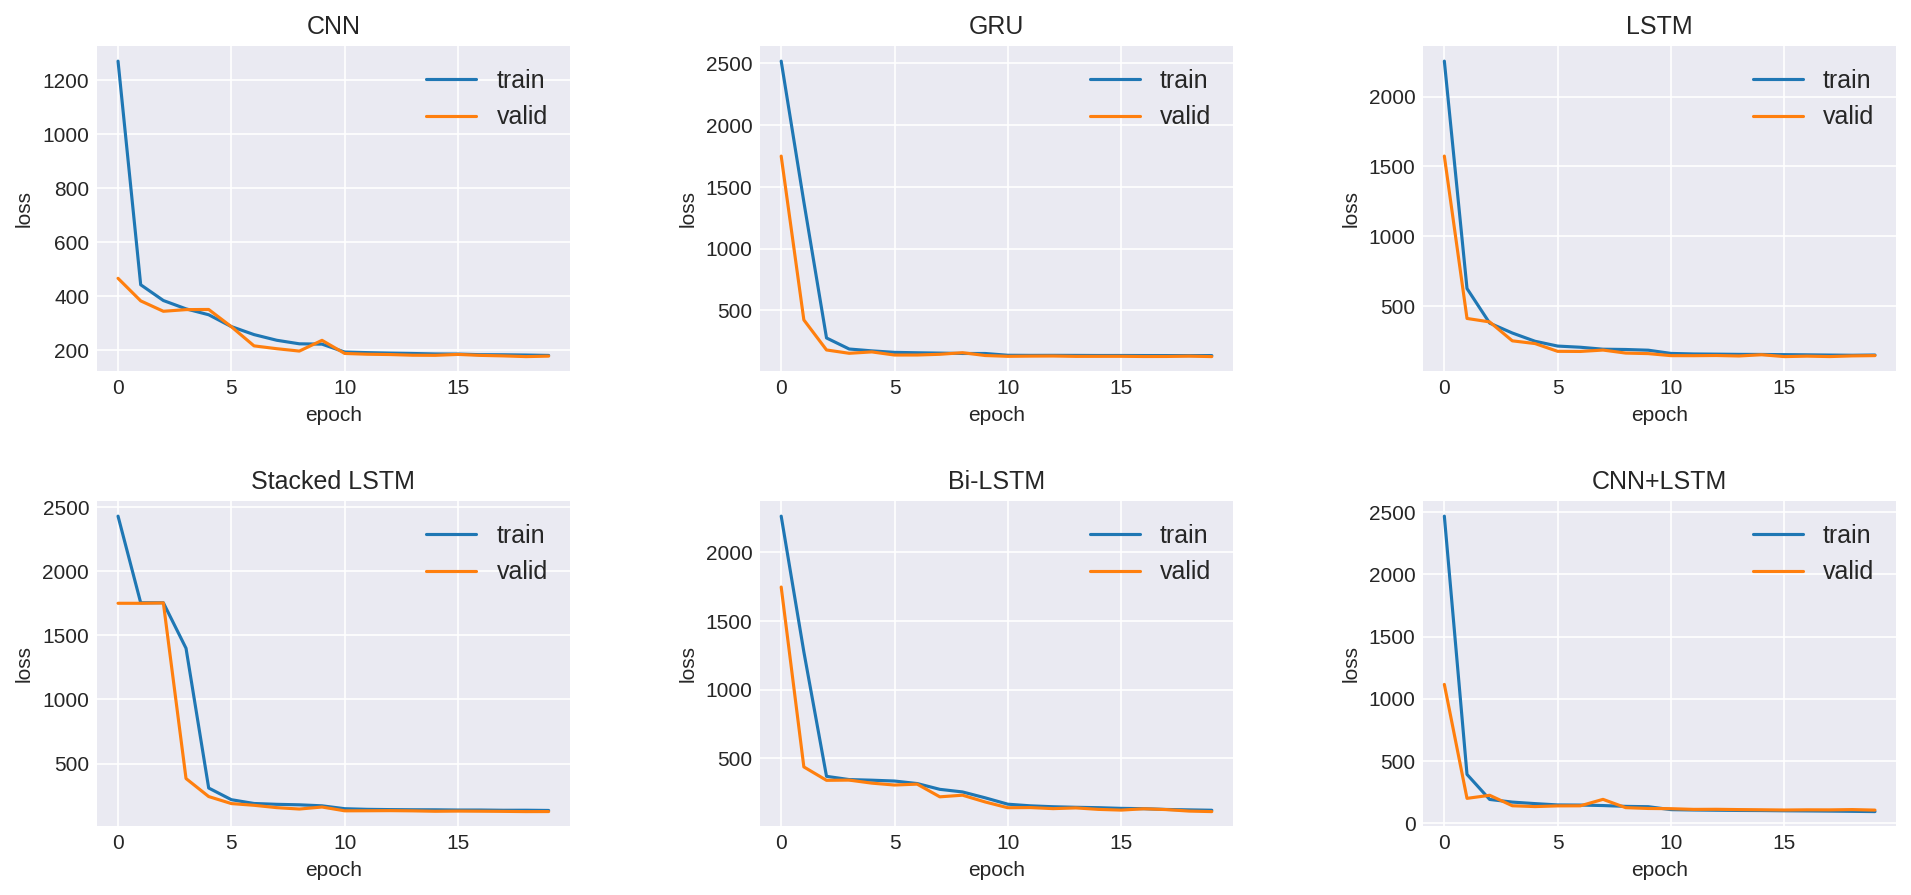

In [ ]:
model_name = ['CNN','GRU','LSTM','Stacked LSTM','Bi-LSTM','CNN+LSTM']

plt.figure(figsize = (20, 4), dpi = 150)
plt.style.use('seaborn-dark') # seaborn-dark-palette / ggplot /bmh /seaborn-dark
plt.subplots_adjust(left = 0.1, bottom = 0.2, right = 0.7, top = 1.5, wspace = 0.4, hspace = 0.4)
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.plot( history_train_loss[i] )
  plt.plot( history_val_loss[i] )
  plt.title(model_name[i])
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'valid'],fontsize =12)
  plt.grid('on')
plt.show()

In [ ]:
# %reload_ext tensorboard
# %tensorboard --logdir='./logs'

## Plot real data and the predicted one to make some comparison

In [ ]:
def plot_predActual(y_test, y_predictions,model_name):
  plt.style.use('seaborn-white')
  plt.rcParams['figure.figsize']=20,5
  fig,ax = plt.subplots()
  plt.title( model_name +' prediction result',fontsize =16)
  plt.ylabel('RUL',fontsize =16)
  plt.xlabel('Test Engine Units',fontsize =16)
  g = sns.lineplot(x = np.arange(0,len(train['unit_number'].unique())),y = y_test,color='lightseagreen',label = 'actual',ax=ax)
  f = sns.lineplot(x = np.arange(0,len(train['unit_number'].unique())),y = y_predictions,color='salmon',label = 'predictions',ax=ax)
  ax.grid(True)
  ax.legend()
  plt.show()

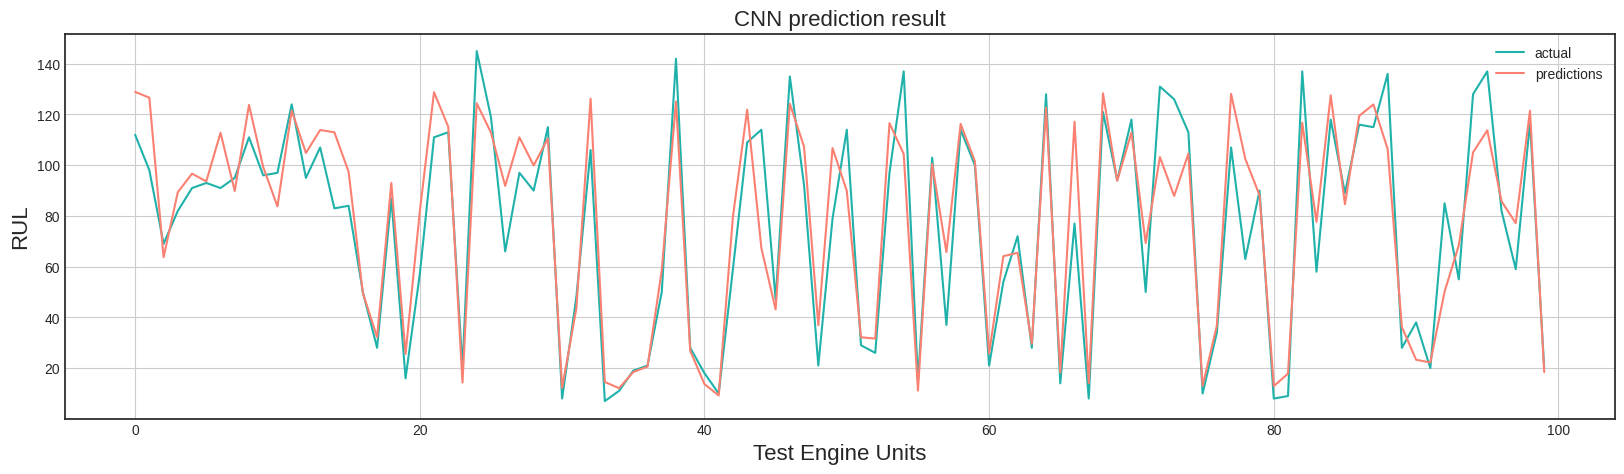

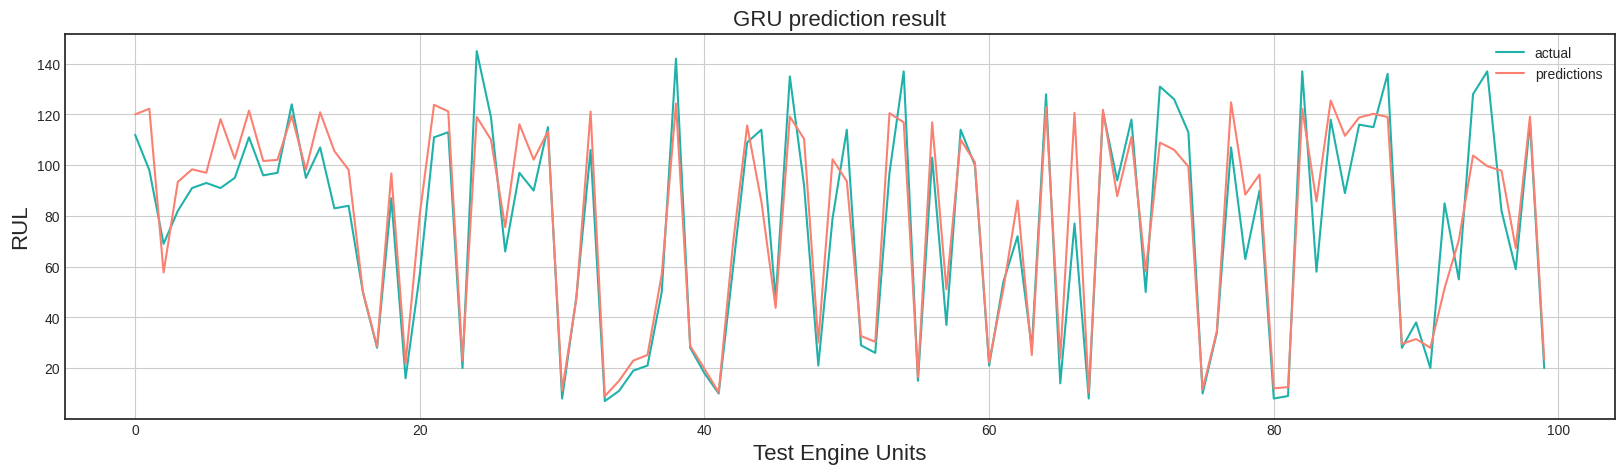

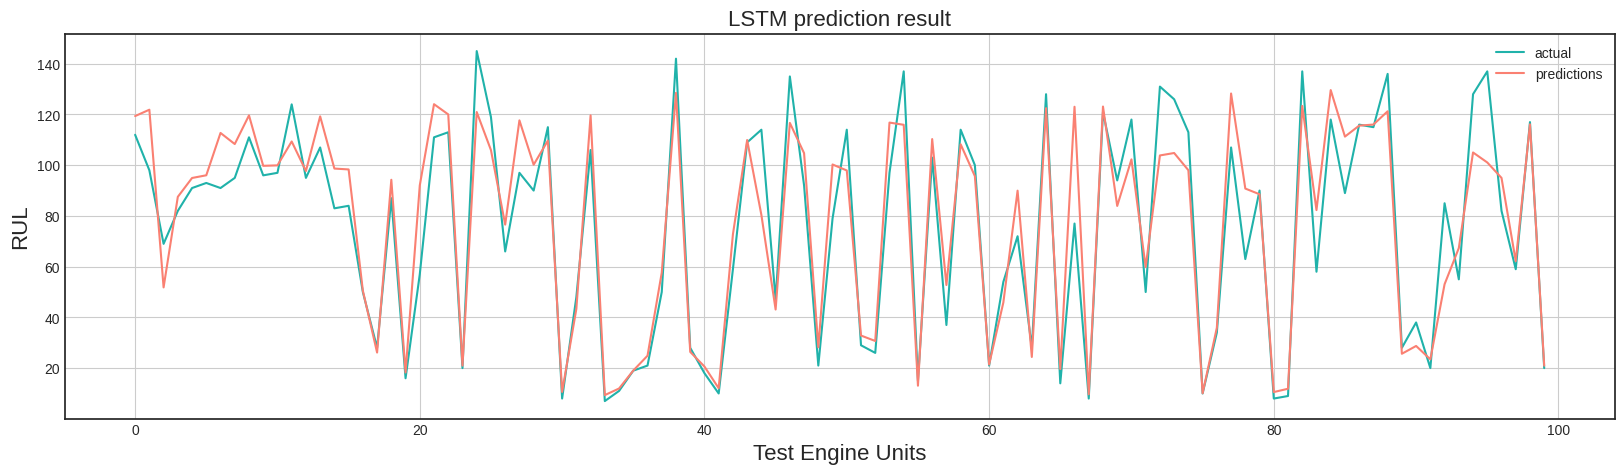

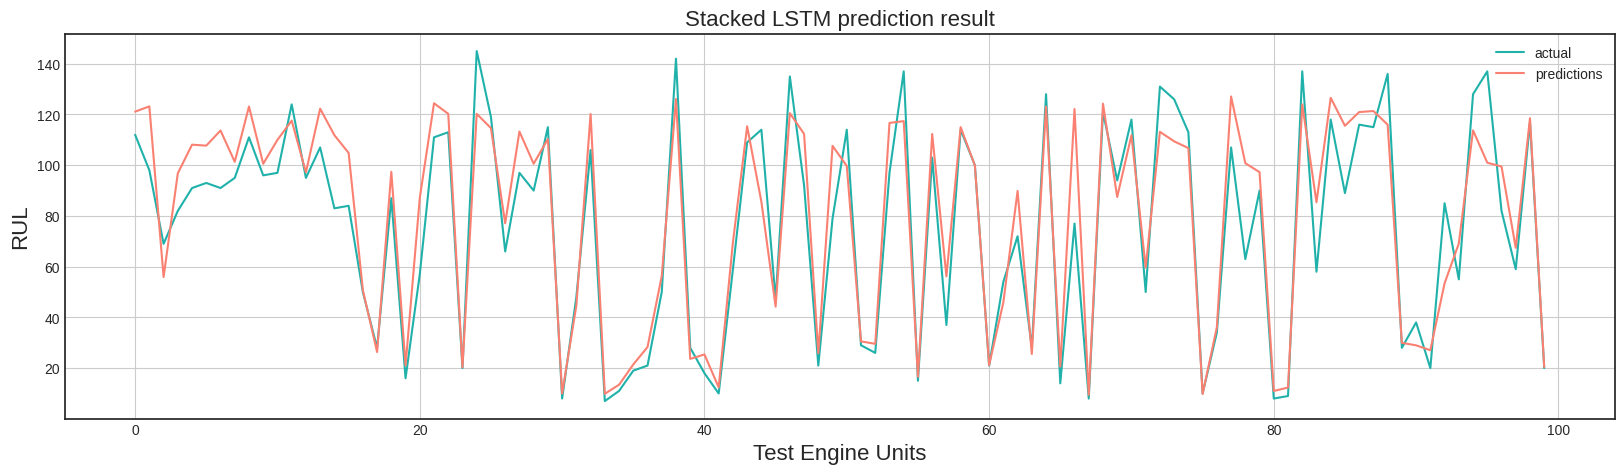

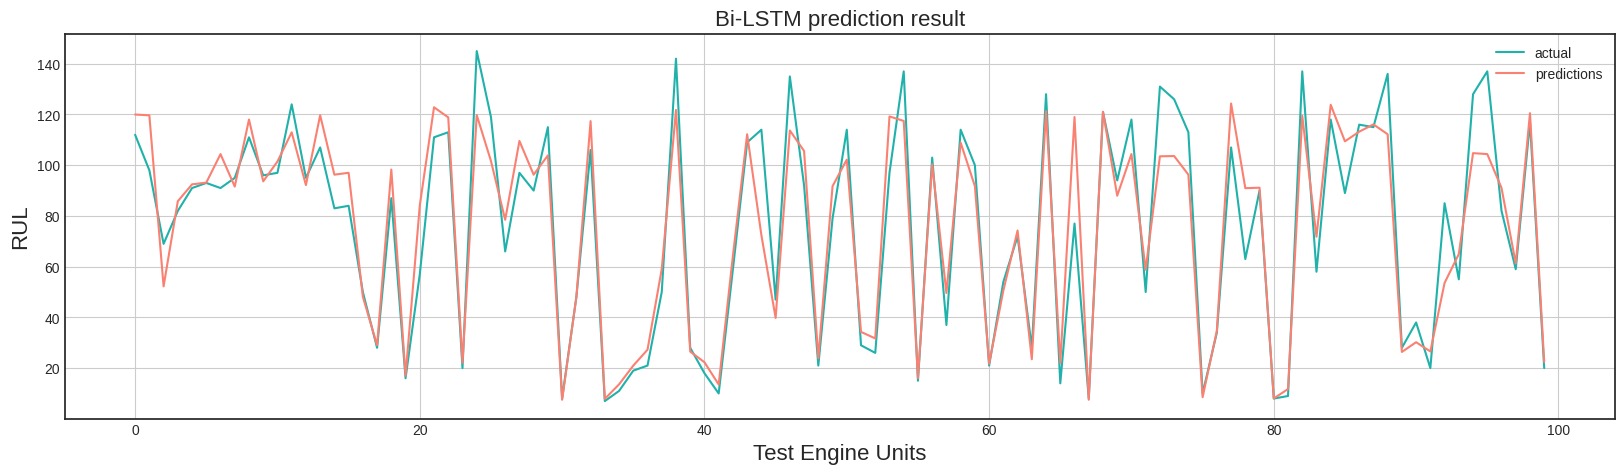

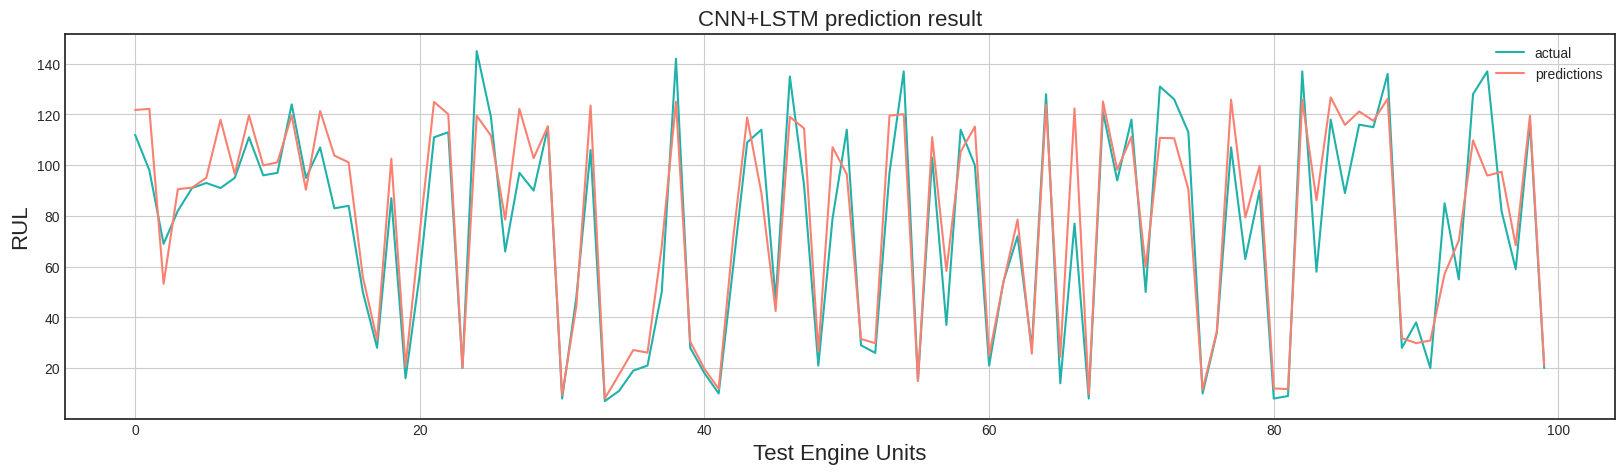

In [ ]:
for model_name, model in models.items():
  rul_pred = model.predict(processed_test_data,verbose=0).reshape(-1)
  preds_for_each_engine = np.split(rul_pred, np.cumsum(num_test_windows_list)[:-1])
  mean_pred_for_each_engine = [np.average(ruls_for_each_engine, weights = np.repeat(1/num_windows, num_windows))
                              for ruls_for_each_engine, num_windows in zip(preds_for_each_engine, num_test_windows_list)]
  y_true = true_rul.reshape(1,len(true_rul))[0]
  plot_predActual(y_true, mean_pred_for_each_engine,model_name)
  print(' ')